# Rotational Coordinate Scan

In the previous notebook we optimized the structure of butane. The lowest energy structure is the "anti" conformation. We know that as we turn the central C–C bond that we will pass through an energy barrier of an eclipsed conformation (with CH$_3$ eclipsed against hydrogen) and then settle into the energy well of the gauche conformation. If we keep turning the bond we will pass through the highest energy barrier of the conformation with both methyl groups eclipsed against each other to reach the other gauche conformation. Past that we would complete the full circle and reach the original anti conformation. 

Draw these conformers using Newman projection and convince yourself that the above is true.

## Bring Back Butane

First I will create the molecule object using the data from the optimized structure for butane. Consider the code below.

In [2]:
# use psi4conda environment
import psi4
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import helpers as hp # Many useful functions from https://lcbc-epfl.github.io/iesm-public/intro.html

psi4.core.clean_options()

output_file = "butane_PES_points_1.out"
psi4.set_memory("1GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

# The Z-matrix as a text string ### From previous optimization
data = """
       0 1
       C       
       C             1    1.541090
       H             1    1.085997      2  110.737654
       H             1    1.086006      2  110.607207      3  119.996707
       H             1    1.085996      2  110.737537      3 -120.006541
       C             2    1.545066      1  112.446725      3   59.916254
       H             2    1.088519      1  109.298807      6  121.516910
       H             2    1.088518      1  109.301738      6 -121.519264
       C             6    1.541169      2  112.445221      1    dihedral
       H             6    1.088515      2  109.250918      9  121.551235
       H             6    1.088516      2  109.250874      9 -121.547269
       H             9    1.085998      6  110.604358     10   58.384210
       H             9    1.085992      6  110.745577     12  119.994957
       H             9    1.085994      6  110.746117     12 -119.995065

       symmetry c1
       dihedral  =  179.9414294137
       units angstrom
       """ 

# Create the Molecule object
mol = psi4.geometry(data)             # Create Molecule object from data string

# Set up options for calculations
psi4.set_options({
        "BASIS": "sto-3g",            # default => None - Basis set must be specified
#        "BASIS": "6-31+G(d)",            # default => None - Basis set must be specified
        "SAVE_OPTIMIZATION": True,    # default => False
        "OPT_TYPE": "min",            # default => "min":  "min","irc" or "ts"
        "MAXITER": 100,               # default => 50
        "GEOM_MAXITER": 100,          # default => 50
        "FULL_HESS_EVERY": -1,        # default => -1 -> only perform a calculation at the beginning
        "PRINT": 2,                   # default => 1
        "GUESS": "sad",               # default => auto
        "REFERENCE": "rhf",           # default => rhf
        "SCF_TYPE": "direct",         # default => pk
        "INTS_TOLERANCE": 1E-8,       # default => 1e-12. A value of 1e-8 is recommended when SCF_TYPE set to "direct"
        "PRINT_TRAJECTORY_XYZ_FILE":True,   # default => false
        "PRINT_OPT_PARAMS": True,     # default => False
        "WRITE_TRAJECTORY": True      # default => False
    })


# Optimize the structure
energy_anti, hist = psi4.optimize("hf", molecule = mol, return_history=True)   # get energy of initial optimized structure
                                                                               # should I have used psi4.energy() instead?
print(f"Initial energy is {energy_anti:0.7f} Hartrees")


  Memory set to 953.674 MiB by Python driver.
Optimizer: Optimization complete!
Initial energy is -155.4666462 Hartrees


## Finding Higher Ground

We can see if the structure will "fall" into the higher-energy gauche conformation and stay there if we start within that energy well. I will take the starting dihedral angle and twist it by 120 degrees (I will just subtract 120 from the current value). Then I will optimize the geometry so that the methyl groups can rotate to find the lowest-energy gauche conformation. Consider the code below.

In [30]:
mol2 = mol.clone()                    # make a copy of the molecule.

start_angle = mol2.get_variable("dihedral")
print(f"Before rotation: {start_angle:.3f} degrees") 

start_angle = start_angle - 120
print(f"After rotation: {start_angle:.3f} degrees\n") 
mol2.set_variable("dihedral", start_angle)


energy_gauche, hist = psi4.optimize("hf", molecule = mol2, return_history=True)
print(f"The optimized energy for this configuration is {energy_gauche:.7f} Hartree\n")

mol2.print_out()
mol2.print_distances()
mol2.print_bond_angles()
mol2.print_in_input_format()

dihedral_angle = mol2.get_variable("dihedral")
#opt_length = mol.get_variable("length")

print(f"After optimization: {dihedral_angle:.3f} degrees\n") 

Before rotation: 179.994 degrees
After rotation: 59.994 degrees

Optimizer: Optimization complete!
The optimized energy for this configuration is -155.4651812 Hartree

After optimization: 60.005 degrees



In [31]:
e_diff = ((energy_gauche - energy_anti) * psi4.constants.hartree2kJmol)
print(f"The energy difference is {e_diff:0.2f} kJ/mole")
hp.drawXYZSideBySide(mol, mol2)

The energy difference is 3.85 kJ/mole


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Comparing Anti and Gauche

Consider the code below. We will calculate the energy difference between the two conformations and also display the conformations side-by-side using another function in the ```helpers``` module. We see that the energy difference between anti and gauche is 3.5 kJ/mole. the literature value is between 3.6 and 3.8 kJ/mole. So our very simple calculation did a decent job of calculating the energy difference.

Examine the side-by-side comparison below. Note that the lowest energy geometry has a torsion angle of about 66.5 degrees rather than the cannonical value of 60 degrees expected for a gauche conformer. This is becasue of the steric bulk of the methyl groups. they push away from each other and the angle gets cheated slightly larger to lessen the amount of steric strain.

## Climbing the Summit

The path from anti to gauche and from gauche to the other gauche and then on back to anti desctibes a full circle for the torsion angle. We have found geometries that represent two stable conformations that are energy minima. We can convert from one to the other but must pass through a higher-energy structure to do so. How can we find this high-energy structure if the optimization algorithm want to find a way downhill at all times.

One way is to constrain the torsion angle. There are two possible eclipsed conformations. One is where methyl groups eclipse hydrogen groups and the other is when the methy groups eclipse each other. These will occur at torsion angles of 120 and zero degrees.

### Forcing a Molecular Eclipse

We will set the torsion angle to 120 degrees. Draw the structure in Newman projection and confirm this for yourself. This will place both methyl groups in eclipse with a hydrogen group. 

There are two ways (that I know - there may be more) to do this. One we have explored already when we used constrainsts to examine the energy of water with different bend angles. We set the bend to a value and then locked that value. We optimized the molecule allowing all other coordinates to change, except the frozen bend angle. In this case we would set the "dihedral" variable in the molecule to a value, freeze it, and then optimize. We would use ```mol.set_variable("dihedral", some_value)``` and ```psi4.set_options({"FROZEN_DIHEDRAL":"9 6 2 1"})``` to do this here.

The other option is to use ```psi4.set_options({"RANGED_DIHEDRAL": "9 6 2 1 119.90 120.01"})```.  This sets the goal for the dihedral angle to be 120 degrees (between the two narrowly spaced range values). It does not chnage y=the initial value of the angle and the optimization will apply an artificial gradient that moves the coordinate toward the range. this can be messy and fail if it forces atoms to pass through each other or any other impossible situations. 

the first option is easily accessible when using internal coordinates such as a Z-matrix. The second option is the only way to set desired angles when the input is a cartesian coordinate matrix. So they both have their uses and, in this case, should both work equally well.

### Using FROZEN_DIHEDRAL

Consider the code below. Use the slider in the viewer window to follow the optimization. Observe that we start with a given, frozen dihedral and optimize the rest of the system.

Optimizer: Optimization complete!
The optimized energy for this configuration is -155.4612372 Hartree

The energy difference for torsion = 120 eclipsed is 14.20 kJ/mole
After optimization: 120.001 degrees



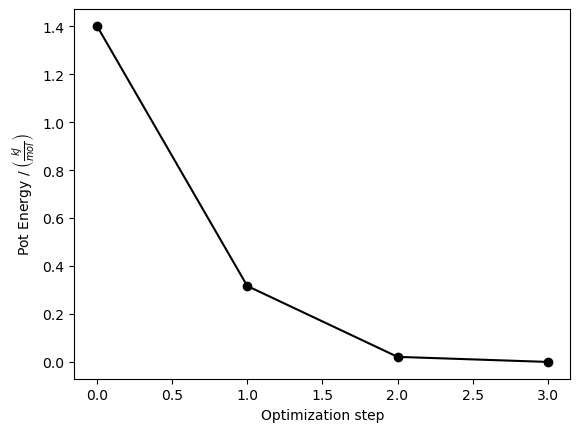

interactive(children=(IntSlider(value=0, description='conf', max=3), Output()), _dom_classes=('widget-interact…

In [33]:
### We start with the optimized molecule for the gauche conformer => mol2

mol3 = mol2.clone()  # Copy it into a new molecule to preserve the geometry of the original.
                     # We will now proceed with mol3

# We will not change the settings that were created above.

output_file = "butane_eclipsed_1.out"
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)

psi4.set_options({"FROZEN_DIHEDRAL":"9 6 2 1"})
mol3.set_variable("dihedral", 120)

energy_eclipse_120, hist = psi4.optimize("hf", molecule = mol3, return_history=True)
print(f"The optimized energy for this configuration is {energy_eclipse_120:.7f} Hartree\n")
e_diff = ((energy_eclipse_120 - energy_anti) * psi4.constants.hartree2kJmol)
print(f"The energy difference for torsion = 120 eclipsed is {e_diff:0.2f} kJ/mole")
dihedral_angle = mol3.get_variable("dihedral")
print(f"After optimization: {dihedral_angle:.3f} degrees\n") 

# a = np.array(hist["energy"])                # print the energies at each step
# b = ((a - a[-1]) * psi4.constants.hartree2kJmol)
# for c in b: print(f"{c:10.3f}")

fig, ax =  plt.subplots(1)                    # Create a blank plot in a figure

energies = np.array(hist["energy"])           # Get the list of energies from the history of the optimization
energies = (energies - energies[-1]) * psi4.constants.hartree2kJmol   # relative energy in kJ/mole

ax.plot(energies, "ko-")                      # Plot the energies at each step
ax.set_xlabel('Optimization step')
ax.set_ylabel(r'Pot Energy /$\;\left(\frac{kJ}{mol}\right)$')
plt.show()
    
coordinates = hist["coordinates"]             # Visualiza the structures at each step
traj = hp.mol2traj(mol, coordinates)
hp.drawXYZGeomSlider(traj)

### Using RANGED_DIHEDRAL

Consider the code below. Use the slider in the viewer window to follow the optimization. Observe that we start with the original angle and the driver moves the angle to the goal. This wroked well when the difference between goal and start was small but failed when I started with a dihedral of 60 degrees and a goal of 120 degrees. It worked up to a goal of 90 degrees and then had trouble optimizing. Perhaps I need to loosen the criteria for ending the optimization? There are many ways to approach getting this to work better and I know none of them.

The code below did not give the desired result. Large differences between the start and goal values caused the optimization to crash. the higher energy structures that were closer to the starting position failed to optimize (required more steps than the ```MAXITER```step limit). I was not able to set a goal higher than 90 degrees that worked.

Run the code below and change the value for ```goal``` if you like. This method for constraining a torsion angle is not working for me in this case. You can read up of the end conditions for optimization in *Psi4* and perhaps loosen the parameters so that the optimization is able to decide to finish under less perfect conditions. There may be other tweaks needed.

For future work we will use the ```FROZEN_DIHEDRAL``` method. The FROZEN_DISTANCE, _BEND or _DIHEDRAL method optimizes much more quickly and with success. The ```RANGED_DIHEDRAL``` method was messy, as promised. We may return to this in other systems where internal coordinates are difficult to manage, such as cyclic systems. But, until we absolutely need to use RANGED_DIHEDRAL we will stick with FROZEN_DIHEDRAL and related settings for constraints.

Update: I added in the CHEAT! line below to set the dihedral angle in the molecule to be close to the goal angle. We can only do this while using internal coordinates like the Z-matrix. Starting close to you optimized structure is the key to good optimization.

Optimizer: Optimization complete!
The optimized energy for this configuration is -155.4612372 Hartree

The energy difference for torsion = 120 eclipsed is 14.20 kJ/mole
After optimization: 119.899 degrees



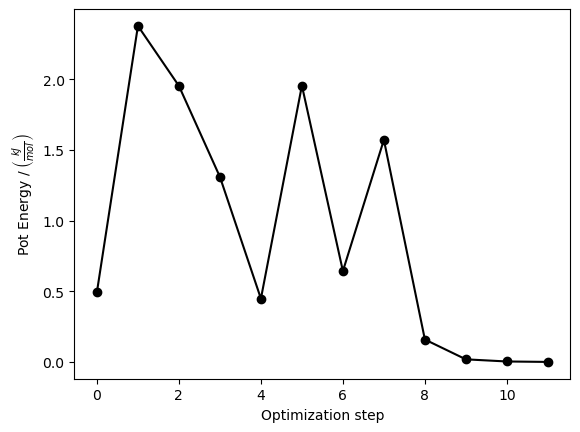

interactive(children=(IntSlider(value=0, description='conf', max=11), Output()), _dom_classes=('widget-interac…

In [35]:
### We start with the optimized molecule for the gauche conformer => mol2

mol4 = mol2.clone()  # Copy it into a new molecule to preserve the geometry of the original.
                     # We will now proceed with mol3

# We will not change the settings that were created above.
psi4.set_options({"FROZEN_DIHEDRAL":""})     # Clear FROZEN_DIHEDRAL


output_file = "butane_eclipsed_2.out"
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)

goal = 120
psi4.set_options({"RANGED_DIHEDRAL":f"9 6 2 1 {goal-.1} {goal+.1}"})

# CHEAT!!! Set the value to near the the goal ahead of time. 
mol4.set_variable("dihedral", 110)     # Setting the variable to the same as the goal will allow the system to optimize quickly
                                       # But this won't work with cartesian coordinates

energy_eclipse_120, hist = psi4.optimize("hf", molecule = mol4, return_history=True)
print(f"The optimized energy for this configuration is {energy_eclipse_120:.7f} Hartree\n")

e_diff = ((energy_eclipse_120 - energy_anti) * psi4.constants.hartree2kJmol)
print(f"The energy difference for torsion = 120 eclipsed is {e_diff:0.2f} kJ/mole")

dihedral_angle = mol4.get_variable("dihedral")
print(f"After optimization: {dihedral_angle:.3f} degrees\n") 


# a = np.array(hist["energy"])                 # print the energies at each step     
# b = ((a - a[-1]) * psi4.constants.hartree2kJmol) 
# for c in b: print(f"{c:10.3f}")

fig, ax =  plt.subplots(1)                     # Create a blank plot in a figure

energies = np.array(hist["energy"])            # Get the list of energies from the history of the optimization
energies = (energies - energies[-1]) * psi4.constants.hartree2kJmol   # relative energy in kJ/mole

ax.plot(energies, "ko-")                       # Plot the energies at each step
ax.set_xlabel('Optimization step')
ax.set_ylabel(r'Pot Energy /$\;\left(\frac{kJ}{mol}\right)$')
plt.show()
    
coordinates = hist["coordinates"]              # Visualize the structures at each step
traj = hp.mol2traj(mol, coordinates)
hp.drawXYZGeomSlider(traj)

## The PES Scan for Bond Rotation in Butane

We have explored methods for determining the structures and energies for the stable anti and gauche conformers of butane. We observed that the most stable anti conformer had a torsion angle of 180 degrees. The most stable gauche conformer was 3.49 kJ/mole higher in energy and with an angle of 66.5 degrees. These optimizations were not constrained although we had to start with structures that were close to the goals.

We used the FROZEN_DIHEDRAL setting to freeze the torsion angle and set it to 120 degree and 0 degrees to get the optimized energies for the two eclipsed forms. The energies were 14.20 and 24.43 kJ/mole higher in energy compared to the anti conformer.

These are only four points in the full turn. What if we wanted to explore the whole 360 degree spin and calculaue the energy of the optimized geometries with each value of the torsion angle.

### Scanning the Bond Angle

Below we will use the code that we wrote when we scanned the bend angle of water. I will make small changes so that it is changing the dihedral angle of our butane instead. Then we will plot the energies w.r.t. torsion angle.

In [46]:
# use psi4conda environment
import psi4
import os
import numpy as np
import matplotlib.pyplot as plt

import helpers as hp # Many useful functions from https://lcbc-epfl.github.io/iesm-public/intro.html

psi4.core.clean_options()

psi4.set_options({
        "BASIS": "sto-3g",            # default => None - Basis set must be specified
#        "BASIS": "6-31+G(d)",            # default => None - Basis set must be specified
#        "BASIS": "cc-pvdz",
        "SAVE_OPTIMIZATION": True,    # default => False
        "OPT_TYPE": "min",            # default => "min":  "min","irc" or "ts"
        "MAXITER": 100,               # default => 50
        "GEOM_MAXITER": 100,          # default => 50
        "FULL_HESS_EVERY": -1,        # default => -1 -> only perform a calculation at the beginning
        "PRINT": 2,                   # default => 1
        "GUESS": "sad",               # default => auto
        "REFERENCE": "rhf",           # default => rhf
        "SCF_TYPE": "direct",         # default => pk
        "INTS_TOLERANCE": 1E-8,       # default => 1e-12. A value of 1e-8 is recommended when SCF_TYPE set to "direct"
        "PRINT_TRAJECTORY_XYZ_FILE":True,   # default => false
        "PRINT_OPT_PARAMS": True,     # default => False
        "WRITE_TRAJECTORY": True      # default => False
    })

psi4.set_options({"FROZEN_DIHEDRAL":"9 6 2 1"})

mol5 = mol.clone()   # Copy the optimized anti structure from above

output_file = "Butane_PES_1.out"
psi4.set_memory("4GB")
psi4.set_output_file(output_file, append=False, loglevel=20, print_header=True, inherit_loglevel=True, execute=True)
psi4.core.set_num_threads(4)

step = 10; start = 0; end = 360
number_of_points = (end - start)//step + 1
range_of_values = np.linspace(start, end, number_of_points) 
#range_of_values = [0,60,120,180] 
#range_of_values = [119,119.1,119.2,119.3,119.4,119.5,119.6,119.7,119.8,119.9,120,120.1] 


dihedral_list = []
energy_list = []
geometries = []
for angle in range_of_values:
    mol5.set_variable("dihedral", angle)
    energy = psi4.optimize("hf", molecule = mol5)
    dihedral_list.append(angle)
    energy_list.append(energy)
    geometries.append(mol5.clone())

print("Done")

Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in scalar power
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid value encountered in scalar power
  SRFOmat[:-1, -1] = RFOmat[:-1, -1] / alpha**0.5
/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:684: RuntimeWarning: invalid value encountered in scalar power
  scale_mat = np.diag(np.repeat(1 / alpha**0.5, dim1))


Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!


/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in scalar power
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid value encountered in scalar power
  SRFOmat[:-1, -1] = RFOmat[:-1, -1] / alpha**0.5
/Users/blink/psi4conda/lib/python3.11/site-packages/optking/stepAlgorithms.py:684: RuntimeWarning: invalid value encountered in scalar power
  scale_mat = np.diag(np.repeat(1 / alpha**0.5, dim1))


Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Done


### Visualize Structures

the code below will take the list of optimized geometries for each dihedral angle that was generate above and produce a stack of images that can be navigated by a slider widget. We can follow the changes as we move through the list of diherdal angles and see if anything went off the rails.

In [23]:
energies = np.array(energy_list)
energies = energies - np.min(energies)
energies = energies * psi4.constants.hartree2kJmol


traj = [geom.save_string_xyz_file() for geom in geometries]
traj_arrays = [geom.to_arrays()[0] for geom in geometries]

hp.drawXYZGeomSlider(traj)

#hp.drawXYZGeomSliderMolecularProperty(traj, dihedral_list, energies, 'dihedral')
# for the slider to function properly you must have dihedral angles of exact integers. 
# If that is not the case, adjust the number of dihedrals to divide -180 to 180 degrees into even steps (including the zero value).
# Did not work.  Seems to have a bug in it.


interactive(children=(IntSlider(value=0, description='conf', max=36), Output()), _dom_classes=('widget-interac…

### Analyze the Data

As before, here we will colect the data lists into a dataframe. We will calculate the energy difference relative to the optimized anti conformation in units of kJ/mole. then amke a quick plot using a built-in plot method of the dataframe object.

    angle      energy    kJ/mole
0     0.0 -157.299715  27.119443
1    10.0 -157.300329  25.508004
2    20.0 -157.301929  21.307303
3    30.0 -157.303995  15.882738
4    40.0 -157.305996  10.628680
5    50.0 -157.307503   6.672931
6    60.0 -157.308281   4.629084
7    70.0 -157.308311   4.549484
8    80.0 -157.307701   6.152005
9    90.0 -157.306598   9.048860
10  100.0 -157.305306  12.440646
11  110.0 -157.304290  15.108148
12  120.0 -157.303948  16.006622
13  130.0 -157.304433  14.730935
14  140.0 -157.305616  11.625656
15  150.0 -157.307154   7.589326
16  160.0 -157.308627   3.720264
17  170.0 -157.309670   0.982767
18  180.0 -157.310044   0.000000
19  190.0 -157.309670   0.982664
20  200.0 -157.308627   3.720238
21  210.0 -157.307154   7.589364
22  220.0 -157.305616  11.625969
23  230.0 -157.304433  14.730984
24  240.0 -157.303948  16.006589
25  250.0 -157.304290  15.108095
26  260.0 -157.305306  12.440192
27  270.0 -157.306598   9.048830
28  280.0 -157.307701   6.152056
29  290.0 

<Axes: xlabel='angle', ylabel='kJ/mole'>

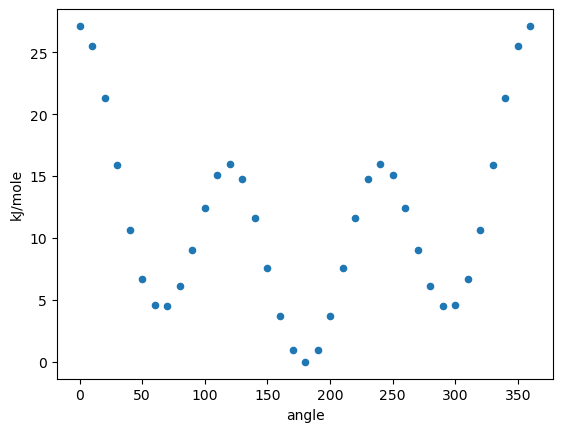

In [47]:
data_dictionary = {"angle": dihedral_list,
                   "energy": energy_list}

df = pd.DataFrame.from_dict(data_dictionary)

df["kJ/mole"] = df["energy"] - np.min(df["energy"])
df["kJ/mole"] = df["kJ/mole"] * psi4.constants.hartree2kJmol
print(df)

df.plot(x="angle", y = "kJ/mole", kind="scatter", )   # try kind="scatter" as well

### A Better Plot

The ```plot()``` method of a dataframe object has all the power of MatPlotLib contained in it. However, I am more familiar with maniplulating MatPlotLib directly

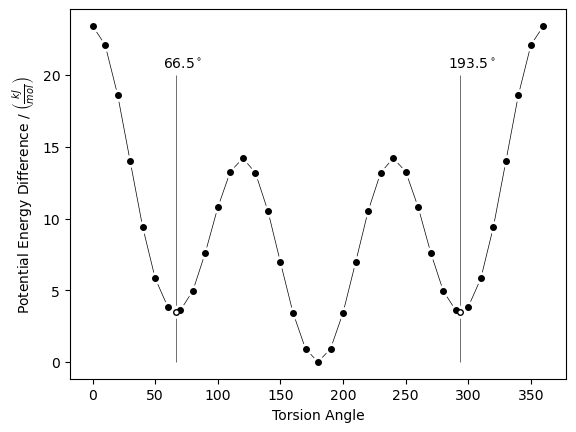

In [28]:
fig, ax =  plt.subplots(1)                     # Create a blank plot in a figure

x = df["angle"]
y = df["kJ/mole"]

ax.plot(x,y, color = "black", linewidth = 0.5, zorder = 0)

ax.scatter(x,y, color = "white", s = 64, zorder = 1)
ax.scatter(x,y, color = "black", s = 16, zorder = 2)

ax.vlines(x = 66.5, ymin = 0, ymax = 20, color = "black", linewidth = 0.4, zorder = 0)
ax.vlines(x = 293.49, ymin = 0, ymax = 20, color = "black", linewidth = 0.4, zorder = 0)

ax.scatter([66.51, 360-66.51], [3.49, 3.49], color = "white", s = 64, zorder = 1)
ax.scatter([66.51, 360-66.51], [3.49, 3.49], color = "white", edgecolor = "black", s = 16, zorder = 2)

ax.text(66.51-10, 20.5,"$66.5^\circ$")
ax.text(293.49-10, 20.5,"$193.5^\circ$")

ax.set_xlabel('Torsion Angle')
ax.set_ylabel(r'Potential Energy Difference /$\;\left(\frac{kJ}{mol}\right)$')

plt.show()

#print(df)

## Conclusions

We obtained the stable stuctures and energies for the anti and gauche conformers of butane. We also evaluated the high-energy eclipsed conformers using a constrained torsion angle. We demonstrated two different methods for constraining the coordinate. Then we used a list of torsion angles to set and constrain the torsion angle from zero to 360 degrees. We optimized each geometry and obtained the optimized energy for each constraint.  This is an example of a "relaxed" potential energy scan (PES).

We plotted the results and saw the expected energy profile. If you have some time on your hands you could repeat the above with a higher level of theory.

## The Next Mystery

We observed that the expected dihedral angle for the energy minimum that defined the gauche conformer was at 66.5 degrees and not exactle 60 degrees. What are the odds that the methyl-hydrogen eclipsed conformer occurs at exactly 120 degrees? Inspection of the energy plot above will reveal an asymmetry on either side of the energy maxdimum near 120 degrees. So its not exactly 120 degrees, but its close.

How can we find the optimized structure for an energy maximum? In the next notebook we will optimize a transition state.